In [60]:
import numpy as np 

Phi= np.load("Data/Kolmogorov/kolmo_100s_8traj.npy")
N,T,D = Phi.shape
print(N,T,D)

8 800 8192


In [61]:
U = Phi[..., :D//2]
V = Phi[..., D//2:]
print(U.shape, V.shape)

(8, 800, 4096) (8, 800, 4096)


In [62]:
U = U.reshape(N,T, int(np.sqrt(D//2)),int(np.sqrt(D//2))) 
V = V.reshape(N,T, int(np.sqrt(D//2)),int(np.sqrt(D//2))) 
print(U.shape, V.shape)

(8, 800, 64, 64) (8, 800, 64, 64)


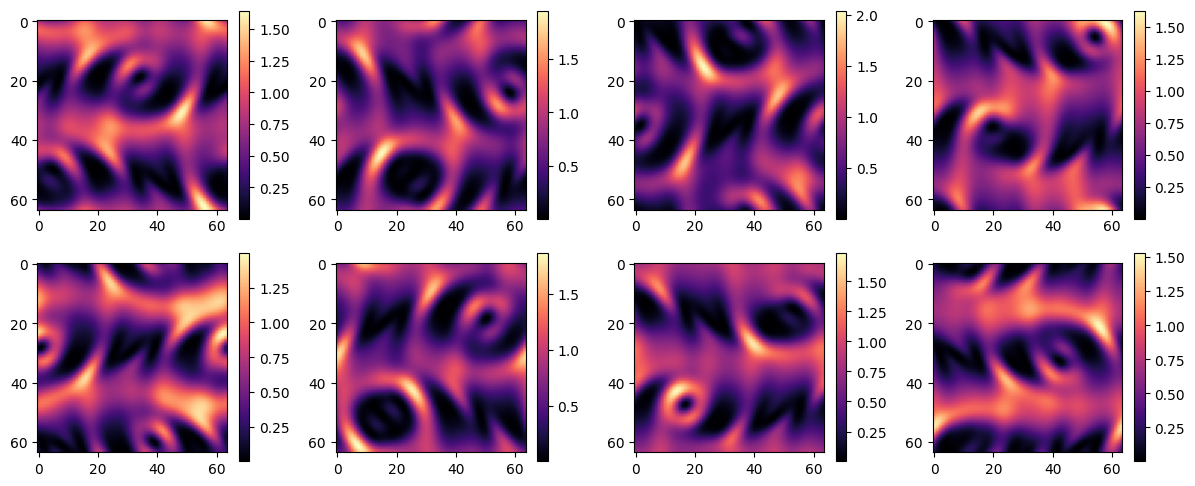

In [63]:
import matplotlib.pyplot as plt

E = 0.5 * (U**2 + V**2) 

index_1 = 500

fig, axes = plt.subplots(2, 4, figsize=(12, 5))

for i in range(8):
    row = i //4
    col = i % 4
    im = axes[row, col].imshow(E[i, index_1, ...], cmap='magma')
    fig.colorbar(im, ax=axes[row, col])

plt.tight_layout()
plt.show()

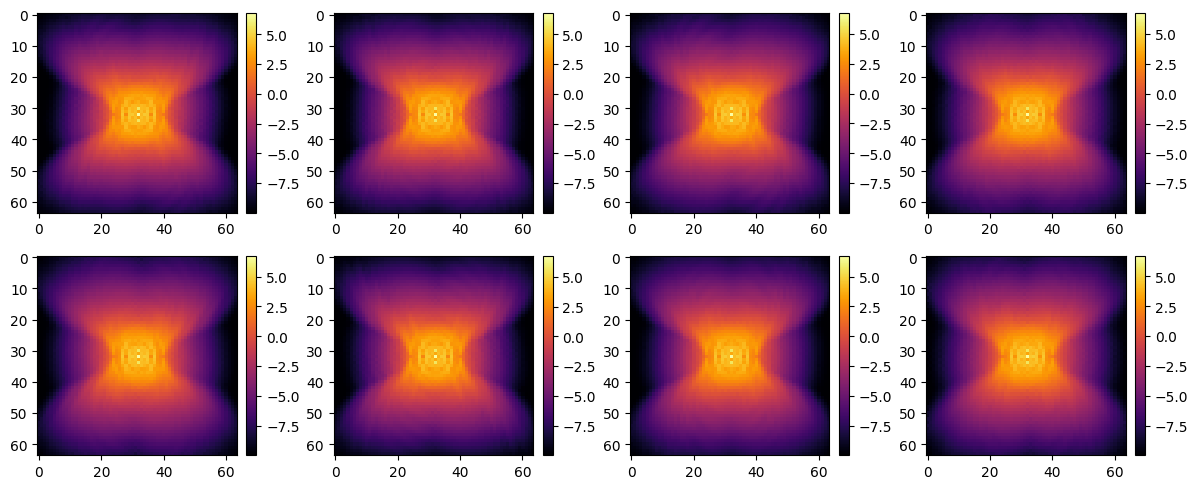

In [64]:
num_series = E.shape[0]

fig, axes = plt.subplots(2,4, figsize=(12, 5))
axes = axes.flatten()  
for i in range(num_series):

    fft_E = np.fft.fft2(E[i], axes=(1, 2))
    energy_spectrum = np.abs(fft_E) ** 2
    average_energy_spectrum = np.fft.fftshift(np.mean(energy_spectrum, axis=0))
    ax = axes[i]
    im = ax.imshow(np.log10(average_energy_spectrum + 1e-10), cmap='inferno')
    # ax.set_title(f'Log of Averaged Energy Spectrum - Series {i+1}')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [65]:
nx = U.shape[-1]
ny = U.shape[-2]
kx = np.fft.fftfreq(nx, d=1.0) 
ky = np.fft.fftfreq(ny, d=1.0)  
kx, ky = np.meshgrid(kx, ky, indexing='ij')
k_magnitude = np.sqrt(kx**2 + ky**2)

In [68]:
U_ref = U[-1]
V_ref = V[-1]

fft_U = np.fft.fft2(U_ref, axes=(1, 2))
energy_spectrum_U = np.abs(fft_U) **2
average_energy_spectrum_U = np.mean(energy_spectrum_U, axis=0)

fft_V = np.fft.fft2(V_ref, axes=(1, 2))
energy_spectrum_V = np.abs(fft_V) **2
average_energy_spectrum_V = np.mean(energy_spectrum_V, axis=0)

k_bins = np.linspace(0, np.max(k_magnitude), 64) 
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])  
spectrum_binned_U = np.zeros_like(k_bin_centers)
spectrum_binned_V = np.zeros_like(k_bin_centers)

for i in range(len(k_bins) - 1):
    mask = (k_magnitude >= k_bins[i]) & (k_magnitude < k_bins[i + 1])
    spectrum_binned_U[i] = np.sum(average_energy_spectrum_U[mask])
    spectrum_binned_V[i] = np.sum(average_energy_spectrum_V[mask])

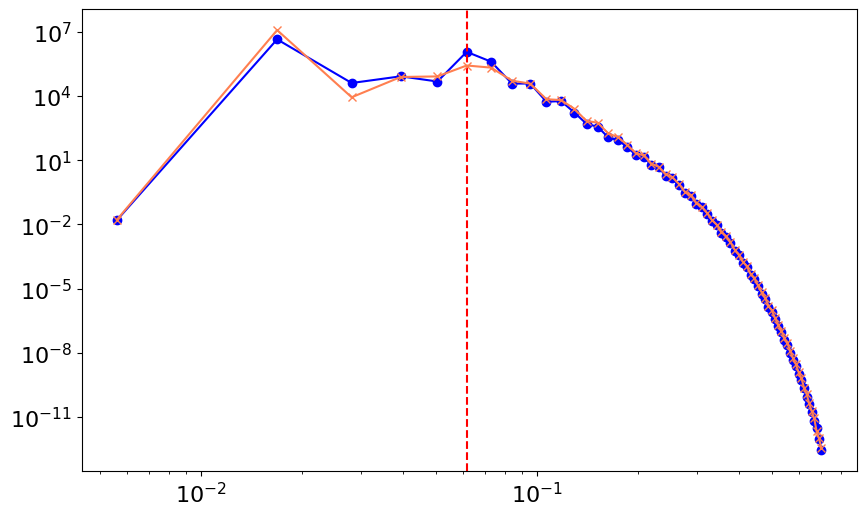

The wavenumber above which 90% of the energy is located: k = 0.06


In [69]:
cumulative_energy_U = np.cumsum(spectrum_binned_U)
total_energy_U = cumulative_energy_U[-1]
normalized_cumulative_energy_U = cumulative_energy_U / total_energy_U

cumulative_energy_V = np.cumsum(spectrum_binned_V)
total_energy_V = cumulative_energy_V[-1]
normalized_cumulative_energy_V = cumulative_energy_V / total_energy_V

target_energy_fraction = 0.90
k_target_U = k_bin_centers[np.searchsorted(normalized_cumulative_energy_U, target_energy_fraction)]
k_target_V = k_bin_centers[np.searchsorted(normalized_cumulative_energy_V, target_energy_fraction)]
k_target = np.max([k_target_U, k_target_V])

plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.loglog(k_bin_centers, spectrum_binned_U, marker='o', linestyle='-', color='b', label='U Energy Spectrum')
plt.axvline(k_target, color='r', linestyle='--', label=f'80% U Energy at k = {k_target:.2f}')
plt.loglog(k_bin_centers, spectrum_binned_V, marker='x', linestyle='-', color='coral', label='V Energy Spectrum')

plt.xlabel('')
plt.ylabel('')

tick_fontsize = 16
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# plt.legend(fontsize=tick_fontsize, loc='upper right')

plt.show()

print(f"The wavenumber above which 90% of the energy is located: k = {k_target:.2f}")


In [70]:
filtered_U_arr = []
filtered_V_arr = []

mask = k_magnitude <= k_target

for i in range(N):

    fft_U = np.fft.fft2(U[i], axes=(1, 2))
    fft_V = np.fft.fft2(V[i], axes=(1, 2))
    
    filtered_fft_U = fft_U * mask
    filtered_fft_V = fft_V * mask
    
    filtered_U = np.fft.ifft2(filtered_fft_U, axes=(1, 2))
    filtered_V= np.fft.ifft2(filtered_fft_V, axes=(1, 2))

    filtered_U_arr.append(filtered_U[np.newaxis, :, :, :])
    filtered_V_arr.append(filtered_V[np.newaxis, :, :, :])

filtered_U_arr = np.concatenate(filtered_U_arr, axis = 0) 
filtered_V_arr = np.concatenate(filtered_V_arr, axis = 0)

print(filtered_U_arr.shape, filtered_V_arr.shape)

(8, 800, 64, 64) (8, 800, 64, 64)


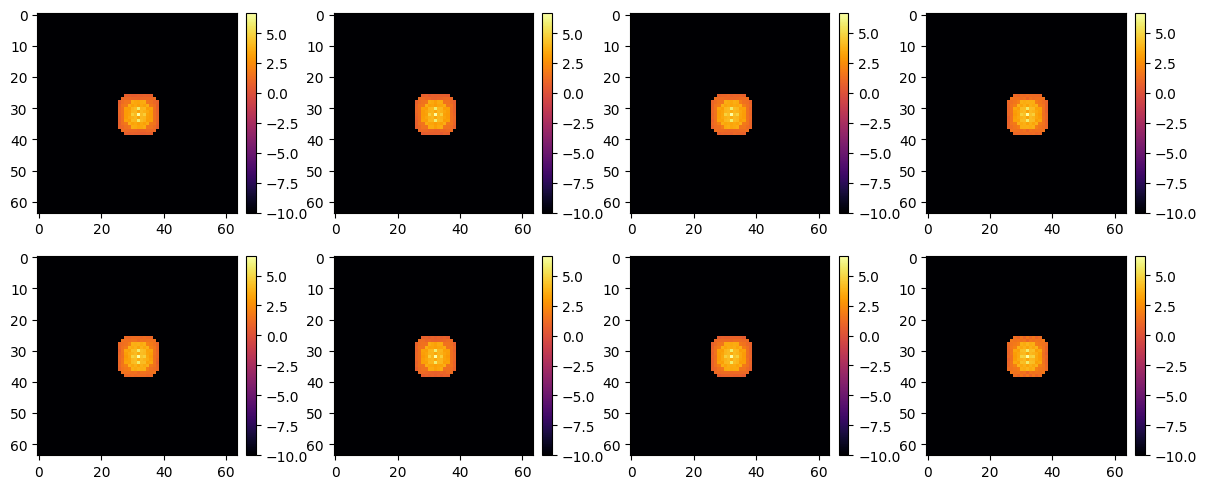

In [71]:
filtered_E_arr = 0.5 * (filtered_U_arr**2 + filtered_V_arr**2) 

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()  
for i in range(N):

    fft_E = np.fft.fft2(filtered_E_arr[i], axes=(1, 2))
    energy_spectrum = np.abs(fft_E) ** 2
    average_energy_spectrum = np.fft.fftshift(np.mean(energy_spectrum, axis=0))
    ax = axes[i]
    im = ax.imshow(np.log10(average_energy_spectrum + 1e-10), cmap='inferno')
    # ax.set_title(f'Log of Averaged Filtered Energy Spectrum - Series {i+1}')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

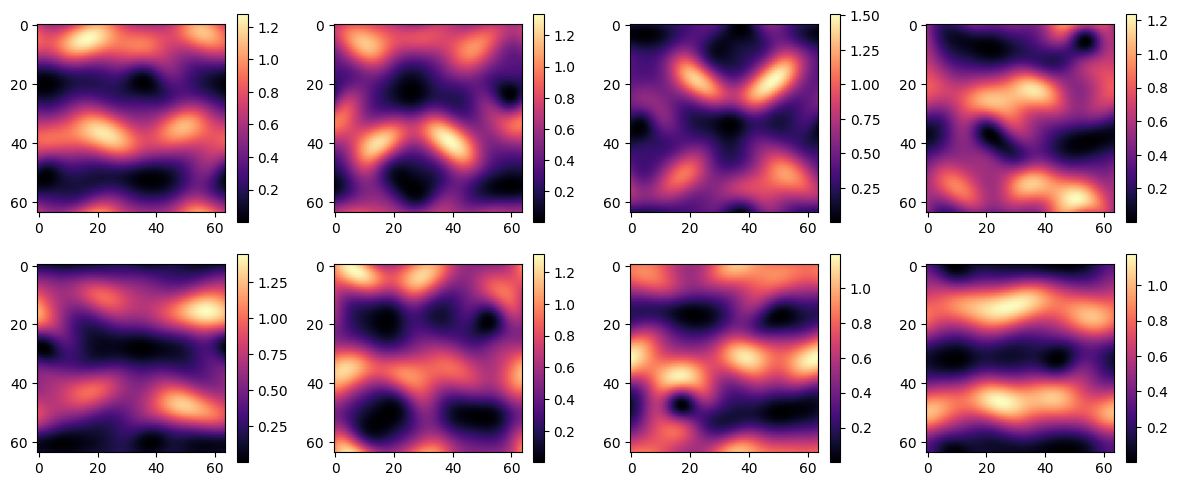

In [72]:
index_1 = 500

fig, axes = plt.subplots(2, 4, figsize=(12, 5))

for i in range(8):
    row = i // 4
    col = i % 4
    im = axes[row, col].imshow(filtered_E_arr[i, index_1, ...].real, cmap='magma')
    fig.colorbar(im, ax=axes[row, col])

plt.tight_layout()
plt.show()

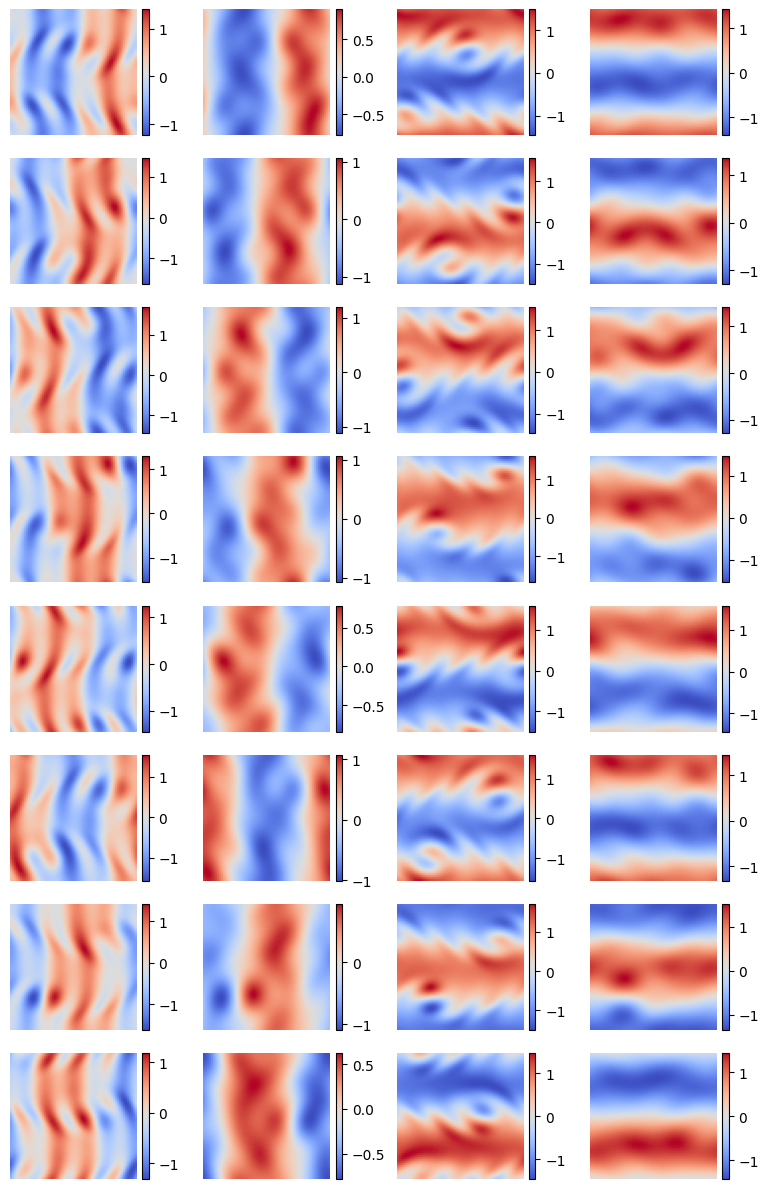

In [73]:
import matplotlib.pyplot as plt

T_plot = 500  # time index to plot
num_fields = 8

fig, axes = plt.subplots(num_fields, 4, figsize=(8,12))

for i in range(num_fields):
    # U unfiltered
    ax = axes[i, 0]
    im = ax.imshow(U[i, T_plot], cmap='coolwarm')
    # ax.set_title(f'Field {i+1} U Unfiltered')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
    
    # U filtered
    ax = axes[i, 1]
    im = ax.imshow(filtered_U_arr[i, T_plot].real, cmap='coolwarm')
    # ax.set_title(f'Field {i+1} U Filtered')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

    # V unfiltered
    ax = axes[i, 2]
    im = ax.imshow(V[i, T_plot], cmap='coolwarm')
    # ax.set_title(f'Field {i+1} V Unfiltered')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

    # V filtered
    ax = axes[i, 3]
    im = ax.imshow(filtered_V_arr[i, T_plot].real, cmap='coolwarm')
    # ax.set_title(f'Field {i+1} V Filtered')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [74]:
filtered_U_arr = filtered_U_arr.reshape(N, T, D//2)
filtered_V_arr = filtered_V_arr.reshape(N, T, D//2)
Phi_filtered = np.concatenate([filtered_U_arr, filtered_V_arr], axis = -1)
print(Phi_filtered.shape)

(8, 800, 8192)


In [75]:
Phi_filtered = Phi_filtered.real
np.save("Data/Kolmogorov/kolmo_filtered_120s_8ens.npy", Phi_filtered) 